<a href="https://colab.research.google.com/github/AaryaAshok77/BrainTumourDetector_DeepLearning/blob/main/Brain_Tumour_Detector_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Setup

## Importing Packages

In [451]:
import sys
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score #? Helps form a yes no matrix for learning, check accuracy of our model
import cv2 #? Helps read image data -> Computer Vision

import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns

from sklearn.model_selection import train_test_split #? Helps split data into training and testing data

## Reading the images

In [452]:
# from google.colab import drive
# drive.mount ('/content/drive', force_remount=True)
# tumour = []
# path_tumour = "/content/drive/MyDrive/DataSets/brain_tumor_dataset/yes/*.jpg"
# path_healthy = "/content/drive/MyDrive/DataSets/brain_tumor_dataset/no/*.jpg"


#* Reading the tumorous images from the dataset
tumour = []
path_tumour = "brain_tumor_dataset/yes/*.jpg"

for f in glob.iglob(path_tumour):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128)) #? Resizing the image to 128x128
    b, g, r = cv2.split(img) #?S plitting the image into its RGB components
    img = cv2.merge([r, g, b], img) #? Merging the RGB components to form the image
    tumour.append(img)
print(f"Tumorous: {len(tumour)}")

#* Reading the healthy images from the dataset
healthy = []
path_healthy = "brain_tumor_dataset/no/*.jpg"

for f in glob.iglob(path_healthy):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b], img)
    healthy.append(img)
print(f"Healthy: {len(healthy)}")

Tumorous: 154
Healthy: 97


In [453]:
tumour = np.array(tumour)
healthy = np.array(healthy)
print(f"Tumorous: {tumour.shape}") #? 155 images of 128x128 pixels with 3 channels (RGB)
print(f"Healthy: {healthy.shape}") #? 98 images of 128x128 pixels with 3 channels (RGB)

Tumorous: (154, 128, 128, 3)
Healthy: (97, 128, 128, 3)


In [454]:
all = np.concatenate((tumour, healthy)) #? Concatenating the tumorous and healthy images to form a single dataset
print(f"All: {all.shape}") #? 253 images of 128x128 pixels with 3 channels (RGB)

All: (251, 128, 128, 3)


### Visualizing the MRI image

In [455]:
def plot_random_img(healthy, tumour, n):
    healthy_imgs =  healthy[np.random.choice(healthy.shape[0], n, replace=False)] #? Randomly selecting 5 healthy images
    tumour_imgs =  tumour[np.random.choice(tumour.shape[0], n, replace=False)] #? Randomly selecting 5 tumorous images

    plt.figure(figsize=(16, 9)) #? Setting the size of the plot
    for img in range(n):
        plt.subplot(1, n, img+1) #? 1-> Row, num-> Column, img+1-> Index
        plt.title('Healthy')
        plt.imshow(healthy_imgs[img])

    plt.figure(figsize=(16, 9))
    for img in range(n):
        plt.subplot(2, n, img+1+n) #? 2-> Row, num-> Column, img+1+n-> Index
        plt.title('Tumorous')
        plt.imshow(tumour_imgs[img])

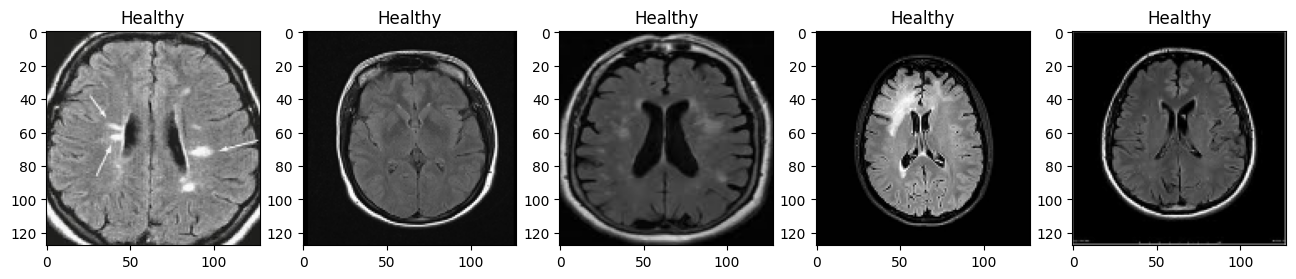

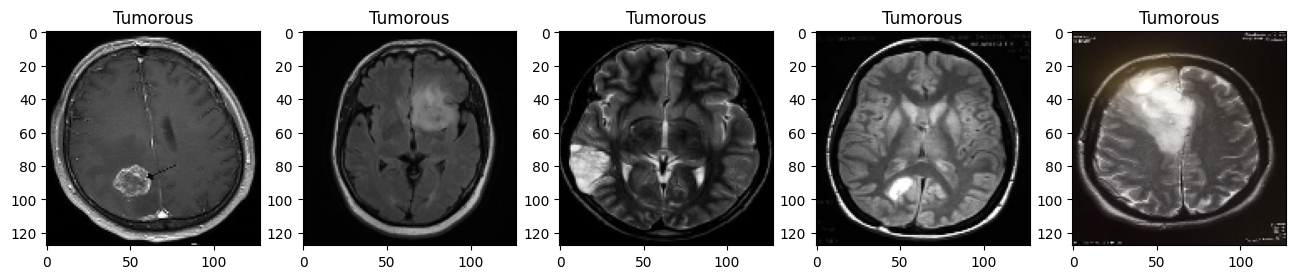

In [456]:
plot_random_img(healthy, tumour, 5)

## Creating MRI Dataset Class

In [457]:
class MRI(Dataset):
    def __init__(self):
        #* Initialising the training and testing data
        self.X_train, self.y_train, self.X_test, self.y_test = None, None, None, None 
        #* Initialising the mode of the dataset
        self.mode = 'train'

        tumour = []
        for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b], img)
            tumour.append(img)

        healthy = []
        for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r, g, b], img)
            healthy.append(img)

        #* Images
        tumour = np.array(tumour, dtype=np.float32)
        healthy = np.array(healthy, dtype=np.float32)

        #* Labels
        tumour_label = np.ones(tumour.shape[0], dtype=np.float32) #? 1-> Tumorous
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32) #? 0-> Healthy

        #* Concatenating the images and labels
        self.images = np.concatenate((tumour, healthy), axis=0) #? axis=0-> Concatenating along the rows ((154, 128, 128, 3)+(97, 128, 128, 3)=(251, 128, 128, 3))
        self.labels = np.concatenate((tumour_label, healthy_label), axis=0)

    def train_test_split(self):
        #* Splitting the data into training and testing data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.images, self.labels, test_size=0.2, random_state=77)
        #? 20% of the data is used for testing, 80% for training, random_state-> Seed for the random number generator

    def __len__(self): #? Returns the length of the dataset
        if self.mode == 'train':
            return self.X_train.shape[0]
        else:
            return self.X_test.shape[0]

    def __getitem__(self, idx): #? Returns the image and its label
        if self.mode == 'train':
            sample =  {'image': np.transpose(self.images[idx], (2, 0, 1)), 'label': self.y_train[idx]}
        else:
            sample =  {'image': np.transpose(self.images[idx], (2, 0, 1)), 'label': self.y_test[idx]}
        return sample
        
    def normalize(self):
        self.images /= 255.0 #? Normalising the images to the range [0, 1]

## Creating MRI Model using CNN

In [458]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_model = nn.Sequential(
            #* Layer 1
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5), #? 3-> Input channels(128*128*3 image), 6-> Output channels, 5-> Kernel size
            #? Output size = (W-F+2P)/S+1 = (128-5+2*0)/1+1 = 124
            nn.Tanh(), #? Activation function (squashes the output to the range [-1, 1])
            nn.AvgPool2d(kernel_size=2, stride=5), #? 2-> Kernel size, 5-> Stride
            #? Output size = (W-F)/S+1 = (124-2)/5+1 = 25
            #* Layer 2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            #? Output size = (W-F+2P)/S+1 = (25-5+2*0)/1+1 = 21
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5)
            #? Output size = (W-F)/S+1 = (21-2)/5+1 = 5
            #! 4*4*16 = 256, 4 is the width and height of the image, 16 is the number of channels after the second convolution
        )
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120), #? 256-> Input features, 120-> Output features
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1) #? 1-> Output feature
        )

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1) #? Flattening the output of the CNN model, 0-> Batch size, -1-> Number of features
        '''
            x = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
            x= x.reshape(2, 2, 2, 2)
            x.size(0) -> 2
            x.view(-1) -> tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
            x.view(x.size(0), -1) -> tensor([[ 1,  2,  3,  4,  5,  6,  7,  8], [ 9, 10, 11, 12, 13, 14, 15, 16]])
        '''
        x = self.fc_model(x)
        x = F.sigmoid(x) #? Activation function (squashes the output to the range [0, 1])
        return x

## Training and Testing

In [459]:
mri_data = MRI()
mri_data.normalize()
mri_data.train_test_split()

In [460]:
train_data = DataLoader(mri_data, batch_size=32, shuffle=True) #? DataLoader helps in creating batches of the data
test_data = DataLoader(mri_data, batch_size=32, shuffle=False)

In [461]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

In [462]:
lr = 0.0001
epoch = 600
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [463]:
epoch_training_loss = []
epoch_testing_loss = []

In [464]:
for e in range(1, epoch):
    train_loss = []
    model.train()
    mri_data.mode = 'train'
    for d in train_data:
        optimizer.zero_grad()
        data = d['image'].to(device)
        label = d['label'].to(device)

        output = model(data)

        error = nn.BCELoss()
        loss = torch.sum(error(output.squeeze(), label))
        loss.backward()

        optimizer.step()
        train_loss.append(loss.item())
    epoch_training_loss.append(np.mean(train_loss))

    testing_loss = []
    model.eval()
    mri_data.mode = 'test'
    with torch.no_grad():
        for d in test_data:
            data = d['image'].to(device)
            label = d['label'].to(device)

            output = model(data)

            error = nn.BCELoss()
            loss = torch.sum(error(output.squeeze(), label))
            testing_loss.append(loss.item())
        epoch_testing_loss.append(np.mean(testing_loss))
    if (e+1)%10 == 0:
        print(f"Epoch: {e+1}, Training Loss: {epoch_training_loss[-1]:.6f}, Testing Loss: {epoch_testing_loss[-1]:.6f}")

Epoch: 10, Training Loss: 0.682213, Testing Loss: 0.634289
Epoch: 20, Training Loss: 0.674544, Testing Loss: 0.642056
Epoch: 30, Training Loss: 0.681872, Testing Loss: 0.636354
Epoch: 40, Training Loss: 0.682582, Testing Loss: 0.635837
Epoch: 50, Training Loss: 0.669649, Testing Loss: 0.632313
Epoch: 60, Training Loss: 0.653088, Testing Loss: 0.631422
Epoch: 70, Training Loss: 0.646626, Testing Loss: 0.629629
Epoch: 80, Training Loss: 0.657599, Testing Loss: 0.627425
Epoch: 90, Training Loss: 0.630418, Testing Loss: 0.635256
Epoch: 100, Training Loss: 0.636611, Testing Loss: 0.639837
Epoch: 110, Training Loss: 0.613748, Testing Loss: 0.652132
Epoch: 120, Training Loss: 0.587400, Testing Loss: 0.676192
Epoch: 130, Training Loss: 0.567724, Testing Loss: 0.709427
Epoch: 140, Training Loss: 0.517357, Testing Loss: 0.744240
Epoch: 150, Training Loss: 0.494966, Testing Loss: 0.792646
Epoch: 160, Training Loss: 0.467481, Testing Loss: 0.852675
Epoch: 170, Training Loss: 0.457025, Testing Loss

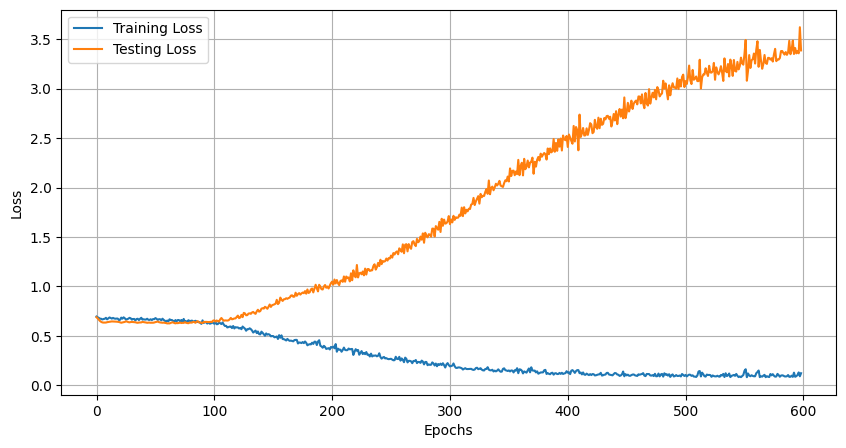

In [465]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_training_loss, label='Training Loss')
plt.plot(epoch_testing_loss, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
#! Clearly our model is overfitting the data